# IMPORT ALL FILES IN ZIP BEFORE RUNNING (FILES SHOULD SHOW UP ON LEFT SIDE OF COLLAB)

DTL Enhanced Signal Combination Strategy
Fetching price data...
✓ TATAMOTORS: 1726 days
✓ MARUTI: 1726 days
✓ M&M: 1726 days
✓ BAJAJ-AUTO: 1726 days
✓ EICHERMOT: 1726 days
✓ ASHOKLEY: 1726 days
✓ HEROMOTOCO: 1726 days
✓ TVSMOTOR: 1726 days

Loading economic indicators...
Loading auto sales data...
Calculating macro features...
Loaded macro data: (2527, 32)
Date range: 2018-01-01 00:00:00 to 2024-12-01 00:00:00
Available columns: ['Sales', 'CPI_Rural', 'Inflation_Rural', 'CPI_Urban', 'Inflation_Urban', 'CPI_Combined', 'Inflation_Combined', 'YearMonth', 'Bank_Rate', 'Repo_Rate']...

Calculating signals...
- Momentum signals...
- Macro signals...
- Combining signals with regime detection...

Constructing portfolio with risk management...
Calculating returns...

Performance Metrics:
--------------------------------------------------
Annual Return................. 19.03%
Annual Volatility............. 19.38%
Sharpe Ratio.................. 0.98
Sortino Ratio................. 1.34
Max Drawdow

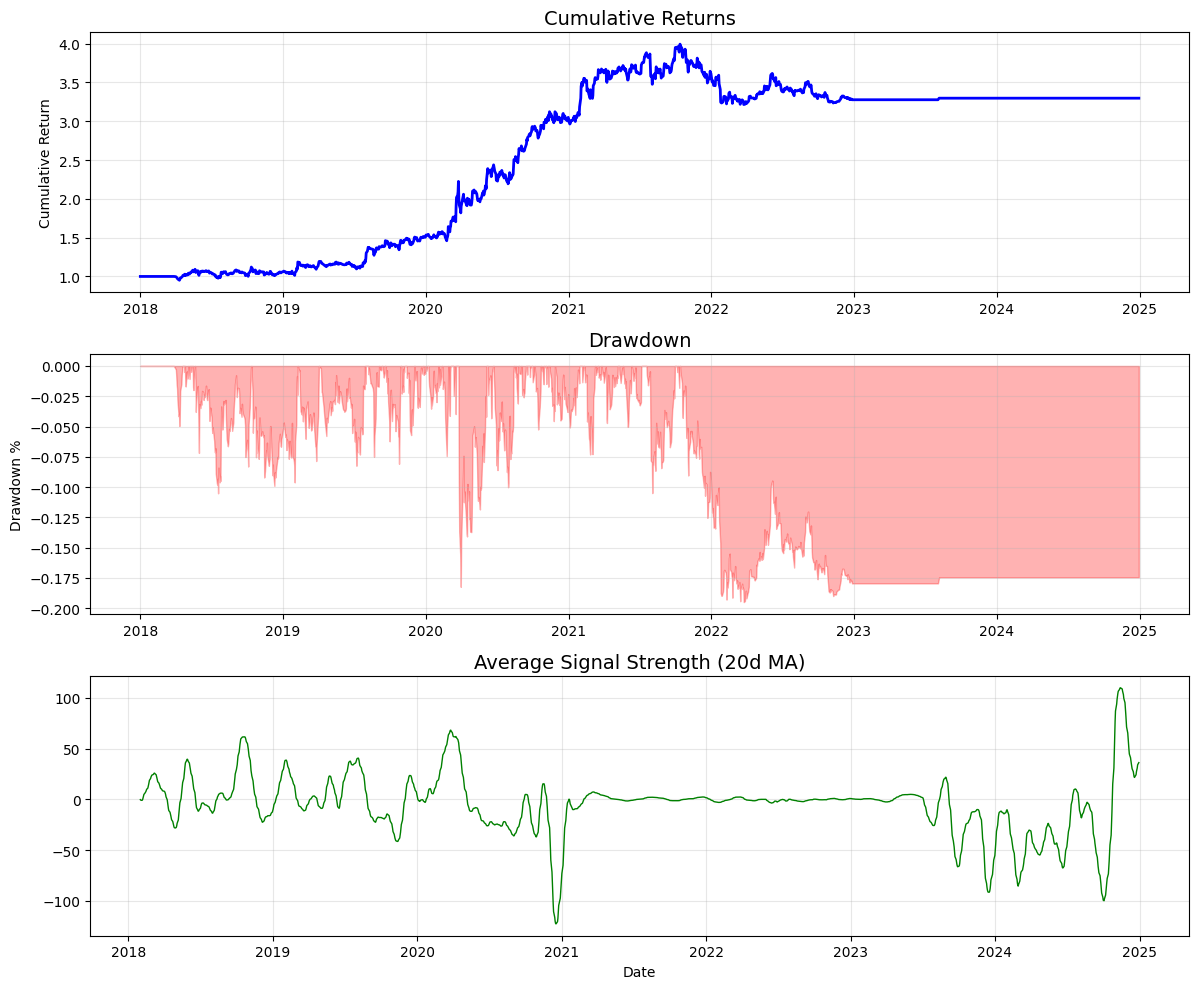

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


def compute_quarterly_sharpe_weights(signal_df, lookback=504):
    """Compute dynamic weights for momentum, policy, and auto signals.

    """
    daily_ret = signal_df.pct_change().fillna(0)
    sharpe = (daily_ret.rolling(lookback).mean() /
              daily_ret.rolling(lookback).std()).mul(np.sqrt(252))

    qs = sharpe.resample("QS").last()
    qs = qs.clip(lower=0)
    qs = qs.div(qs.sum(axis=1), axis=0)
    qs = qs.fillna(1 / len(signal_df.columns))
    weights = qs.reindex(signal_df.index, method="ffill")
    return weights

class SignalCombinationStrategy:

    def __init__(self, tickers, start_date='2018-01-01', end_date='2024-12-31'):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.transaction_cost = 0.001  # 10 bps
        self.max_turnover = 0.40  # 40% daily turnover limit
        self.scaler = RobustScaler()

        # Alternative ticker formats to try
        self.ticker_formats = [
            lambda t: t + '.NS',  # NSE format
            lambda t: t + '.BO',  # BSE format
            lambda t: t,          # Plain ticker
        ]

    def fetch_price_data(self):
        """Fetch OHLCV data for all tickers with volume validation"""
        print("Fetching price data...")
        data = {}

        # Correct NSE ticker mappings
        ticker_map = {
            'TATAMOTORS': 'TATAMOTORS.NS',
            'MARUTI': 'MARUTI.NS',
            'M&M': 'M&M.NS',
            'BAJAJ-AUTO': 'BAJAJ-AUTO.NS',
            'EICHERMOT': 'EICHERMOT.NS',
            'ASHOKLEY': 'ASHOKLEY.NS',
            'HEROMOTOCO': 'HEROMOTOCO.NS',
            'TVSMOTOR': 'TVSMOTOR.NS'
        }

        for ticker in self.tickers:
            try:
                # Use mapped symbol or add .NS suffix
                symbol = ticker_map.get(ticker, ticker + '.NS')
                df = yf.download(symbol, start=self.start_date, end=self.end_date, progress=False, auto_adjust=True)

                if len(df) > 100:  # At least 100 days of data
                    # Check if data is valid
                    if not df.empty and 'Close' in df.columns:
                        data[ticker] = df
                        print(f"✓ {ticker}: {len(df)} days")
                    else:
                        print(f"✗ {ticker}: Invalid data structure")
                else:
                    print(f"✗ {ticker}: Insufficient data ({len(df)} days)")
            except Exception as e:
                print(f"✗ {ticker}: Failed to fetch - {str(e)}")

        # Align all dataframes to common index
        if data:
            # Get the intersection of all dates
            common_index = data[list(data.keys())[0]].index
            for ticker in list(data.keys())[1:]:
                common_index = common_index.intersection(data[ticker].index)

            # Align all data to common dates
            aligned_data = {}
            for ticker in data:
                aligned_data[ticker] = data[ticker].loc[common_index]

            return aligned_data

        return data

    def load_macro_data(self):
        """Load and process actual macro data from CSV files"""
        try:
            # Load economic indicators
            print("\nLoading economic indicators...")
            df_merged = pd.read_csv('df_merged-2.csv')  # Fixed filename

            # Handle date parsing manually if needed
            if 'Date' in df_merged.columns:
                df_merged['Date'] = pd.to_datetime(df_merged['Date'])
                df_merged.set_index('Date', inplace=True)
            else:
                # Try other possible date column names
                date_cols = [col for col in df_merged.columns if 'date' in col.lower()]
                if date_cols:
                    df_merged[date_cols[0]] = pd.to_datetime(df_merged[date_cols[0]])
                    df_merged.set_index(date_cols[0], inplace=True)

            # Load auto sales
            print("Loading auto sales data...")
            auto_sales = pd.read_csv('auto_sales.csv')
            if 'Date' in auto_sales.columns:
                auto_sales['Date'] = pd.to_datetime(auto_sales['Date'])
                auto_sales.set_index('Date', inplace=True)

            # Standardize column names (remove spaces, convert to snake_case)
            df_merged.columns = df_merged.columns.str.strip().str.replace(' ', '_')
            auto_sales.columns = auto_sales.columns.str.strip().str.replace(' ', '_')

            # Calculate derived features
            print("Calculating macro features...")

            # 1. Policy Stance Features
            if 'MSF_Rate' in df_merged.columns and 'Repo_Rate' in df_merged.columns:
                df_merged['liquidity_corridor'] = (df_merged['MSF_Rate'] - df_merged['Repo_Rate']) / (df_merged['Repo_Rate'] + 1e-6)
            else:
                df_merged['liquidity_corridor'] = 0

            if 'Repo_Rate' in df_merged.columns and 'Inflation_Combined' in df_merged.columns:
                df_merged['real_repo_rate'] = df_merged['Repo_Rate'] - df_merged['Inflation_Combined']
            else:
                df_merged['real_repo_rate'] = df_merged.get('Repo_Rate', 0)

            if 'Repo_Rate' in df_merged.columns and 'Reverse_Repo_Rate' in df_merged.columns:
                df_merged['rate_spread'] = df_merged['Repo_Rate'] - df_merged['Reverse_Repo_Rate']
            else:
                df_merged['rate_spread'] = 0

            # Handle SDF Rate (NaN before April 2022)
            if 'SDF_Rate' in df_merged.columns:
                df_merged['sdf_active'] = (~df_merged['SDF_Rate'].isna()).astype(int)
                df_merged['effective_floor_rate'] = df_merged['SDF_Rate'].fillna(
                    df_merged.get('Reverse_Repo_Rate', 0))
            else:
                df_merged['sdf_active'] = 0
                df_merged['effective_floor_rate'] = df_merged.get('Reverse_Repo_Rate', 0)

            # 2. Liquidity Features
            if 'CRR' in df_merged.columns:
                df_merged['crr_change'] = df_merged['CRR'].diff()
            if 'SLR' in df_merged.columns:
                df_merged['slr_change'] = df_merged['SLR'].diff()
            if 'CRR' in df_merged.columns and 'SLR' in df_merged.columns:
                df_merged['reserve_tightness'] = df_merged['CRR'] + df_merged['SLR']
            else:
                df_merged['reserve_tightness'] = 0

            # 3. Inflation Dynamics
            if 'Inflation_Combined' in df_merged.columns:
                df_merged['inflation_acceleration'] = df_merged['Inflation_Combined'].diff()
            if 'Inflation_Urban' in df_merged.columns and 'Inflation_Rural' in df_merged.columns:
                df_merged['urban_rural_divergence'] = df_merged['Inflation_Urban'] - df_merged['Inflation_Rural']

            # 4. Auto Sector Features
            if 'Auto_Sales' in auto_sales.columns:
                auto_sales['auto_sales_yoy'] = auto_sales['Auto_Sales'].pct_change(12) * 100
                auto_sales['auto_sales_mom'] = auto_sales['Auto_Sales'].pct_change(1) * 100
                auto_sales['auto_sales_3m_ma'] = auto_sales['Auto_Sales'].rolling(3).mean()
                auto_sales['sales_momentum'] = auto_sales['auto_sales_3m_ma'].pct_change(3) * 100

            # Merge datasets
            macro_df = pd.merge(df_merged, auto_sales, left_index=True, right_index=True, how='left')

            # Company vs Industry performance
            if 'Sales' in df_merged.columns and 'Auto_Sales' in macro_df.columns:
                macro_df['company_vs_industry'] = (
                    df_merged['Sales'].pct_change(12) -
                    macro_df['Auto_Sales'].pct_change(12)
                ) * 100

                if 'Inflation_Combined' in macro_df.columns:
                    macro_df['real_sales_growth'] = (
                        df_merged['Sales'].pct_change(12) * 100 -
                        macro_df['Inflation_Combined']
                    )

            # Forward fill macro data
            macro_df = macro_df.fillna(method='ffill')

            # Resample to daily frequency
            macro_df = macro_df.resample('D').ffill()

            print(f"Loaded macro data: {macro_df.shape}")
            print(f"Date range: {macro_df.index[0]} to {macro_df.index[-1]}")
            print(f"Available columns: {list(macro_df.columns)[:10]}...")  # Show first 10 columns

            return macro_df

        except Exception as e:
            print(f"Error loading macro data: {e}")
            import traceback
            traceback.print_exc()
            raise

    def calculate_momentum_signal(self, prices):
        """
        Enhanced momentum signal with multiple components - FIXED VERSION
        """
        if not prices:
            return pd.DataFrame()

        # Initialize signals dictionary
        signals = {}

        for ticker, df in prices.items():
            try:
                # FIX 1: Use squeeze() to handle both 1D and 2D cases
                close_prices = df['Close'].squeeze()
                volumes = df['Volume'].squeeze()

                # Price returns at multiple horizons
                ret_1d = close_prices.pct_change(1)
                ret_5d = close_prices.pct_change(5)
                ret_20d = close_prices.pct_change(20)
                ret_60d = close_prices.pct_change(60)

                # Volatility measures
                volatility_10d = ret_1d.rolling(10).std()
                volatility_20d = ret_1d.rolling(20).std()
                volatility_30d = ret_1d.rolling(30).std()

                # Safe division for vol_ratio
                vol_ratio = pd.Series(index=df.index, dtype=float)
                mask = volatility_30d > 1e-6
                vol_ratio[mask] = volatility_10d[mask] / volatility_30d[mask]
                vol_ratio[~mask] = 1.0

                # Risk-adjusted momentum
                sharpe_20d = pd.Series(index=df.index, dtype=float)
                mask = volatility_20d > 1e-6
                sharpe_20d[mask] = ret_20d[mask] / volatility_20d[mask]
                sharpe_20d[~mask] = 0.0

                # Volume-weighted momentum
                dollar_volume = close_prices * volumes
                volume_sum = volumes.rolling(20).sum()
                dv_sum = dollar_volume.rolling(20).sum()

                vwap = pd.Series(index=df.index, dtype=float)
                mask = volume_sum > 0
                vwap[mask] = dv_sum[mask] / volume_sum[mask]
                vwap[~mask] = close_prices[~mask]

                vwap_distance = pd.Series(index=df.index, dtype=float)
                mask = vwap > 0
                vwap_distance[mask] = (close_prices[mask] - vwap[mask]) / vwap[mask]
                vwap_distance[~mask] = 0.0

                # Relative strength
                sma_50 = close_prices.rolling(50).mean()
                sma_200 = close_prices.rolling(200).mean()

                relative_ma = pd.Series(index=df.index, dtype=float)
                mask = sma_200 > 0
                relative_ma[mask] = (sma_50[mask] - sma_200[mask]) / sma_200[mask]
                relative_ma[~mask] = 0.0

                # Mean reversion component
                sma_20 = close_prices.rolling(20).mean()
                bb_upper = sma_20 + 2 * volatility_20d
                bb_lower = sma_20 - 2 * volatility_20d
                bb_width = bb_upper - bb_lower

                bb_position = pd.Series(index=df.index, dtype=float)
                mask = bb_width > 0
                bb_position[mask] = (close_prices[mask] - bb_lower[mask]) / bb_width[mask]
                bb_position[~mask] = 0.5

                mean_reversion = 2 * (0.5 - bb_position)

                # Combine momentum components - ensure all are Series
                momentum = pd.Series(
                    0.20 * ret_5d.fillna(0).values +
                    0.25 * ret_20d.fillna(0).values +
                    0.15 * sharpe_20d.fillna(0).values +
                    0.15 * vwap_distance.fillna(0).values +
                    0.10 * relative_ma.fillna(0).values +
                    0.10 * (1 - vol_ratio).fillna(0).values +
                    0.05 * mean_reversion.fillna(0).values,
                    index=df.index
                )

                # Smooth the signal
                momentum = momentum.rolling(3).mean()

                # Store the signal
                signals[ticker] = momentum

            except Exception as e:
                print(f"Warning: Error calculating momentum for {ticker}: {str(e)}")
                import traceback
                traceback.print_exc()
                signals[ticker] = pd.Series(0, index=df.index)

        # Create DataFrame with proper alignment
        momentum_df = pd.DataFrame(signals)
        return momentum_df

    def calculate_macro_signals(self, macro_df, price_index):
        """
        Process macro signals with sophisticated transformations
        """
        # Align macro data with price data index
        macro_aligned = macro_df.reindex(price_index, method='ffill')
        # Lag macro data by 1 business day to avoid look‑ahead bias
        macro_aligned = macro_aligned.shift(1)

        # Initialize default signals
        policy_signal = pd.Series(0, index=price_index)
        auto_signal = pd.Series(0, index=price_index)

        try:
            # 1. Policy Stance Signal
            if 'liquidity_corridor' in macro_aligned.columns:
                corridor_z = self._calculate_zscore(macro_aligned['liquidity_corridor'], 252)
            else:
                corridor_z = pd.Series(0, index=price_index)

            if 'real_repo_rate' in macro_aligned.columns:
                real_rate_z = -self._calculate_zscore(macro_aligned['real_repo_rate'], 252)
            else:
                real_rate_z = pd.Series(0, index=price_index)

            if 'rate_spread' in macro_aligned.columns:
                spread_change = macro_aligned['rate_spread'].diff(20)
                spread_z = self._calculate_zscore(spread_change, 252)
            else:
                spread_z = pd.Series(0, index=price_index)

            if 'reserve_tightness' in macro_aligned.columns:
                reserve_z = -self._calculate_zscore(macro_aligned['reserve_tightness'], 252)
            else:
                reserve_z = pd.Series(0, index=price_index)

            # Combine policy signals
            policy_signal = (
                0.35 * corridor_z.fillna(0) +
                0.35 * real_rate_z.fillna(0) +
                0.20 * spread_z.fillna(0) +
                0.10 * reserve_z.fillna(0)
            )

            # 2. Auto Sector Health Signal
            if 'auto_sales_yoy' in macro_aligned.columns:
                auto_yoy_z = self._calculate_zscore(macro_aligned['auto_sales_yoy'], 252)
            else:
                auto_yoy_z = pd.Series(0, index=price_index)

            if 'sales_momentum' in macro_aligned.columns:
                auto_mom_z = self._calculate_zscore(macro_aligned['sales_momentum'], 126)
            else:
                auto_mom_z = pd.Series(0, index=price_index)

            if 'Inflation_Combined' in macro_aligned.columns:
                inflation_impact = -self._calculate_zscore(macro_aligned['Inflation_Combined'], 252)
            else:
                inflation_impact = pd.Series(0, index=price_index)

            # Company relative performance (if available)
            if 'company_vs_industry' in macro_aligned.columns and 'real_sales_growth' in macro_aligned.columns:
                relative_z = self._calculate_zscore(macro_aligned['company_vs_industry'], 252)
                real_growth_z = self._calculate_zscore(macro_aligned['real_sales_growth'], 252)

                auto_signal = (
                    0.25 * auto_yoy_z.fillna(0) +
                    0.20 * auto_mom_z.fillna(0) +
                    0.20 * inflation_impact.fillna(0) +
                    0.20 * relative_z.fillna(0) +
                    0.15 * real_growth_z.fillna(0)
                )
            else:
                auto_signal = (
                    0.40 * auto_yoy_z.fillna(0) +
                    0.35 * auto_mom_z.fillna(0) +
                    0.25 * inflation_impact.fillna(0)
                )

        except Exception as e:
            print(f"Warning in macro signal calculation: {e}")
            # Return default signals if error

        return policy_signal, auto_signal

    def _calculate_zscore(self, series, lookback):
        """Calculate expanding z-score with minimum lookback"""
        # Ensure we have a valid series
        if series is None or len(series) == 0:
            return pd.Series(0, index=series.index if hasattr(series, 'index') else pd.DatetimeIndex([]))

        min_periods = min(20, len(series))  # At least 20 periods for stable stats
        mean = series.expanding(min_periods=min_periods).mean()
        std = series.expanding(min_periods=min_periods).std()

        # Avoid division by zero
        zscore = pd.Series(0, index=series.index)
        mask = std > 1e-6
        zscore[mask] = (series[mask] - mean[mask]) / std[mask]

        return zscore

    def combine_signals_advanced(self, momentum_df, policy_signal, auto_signal):
        """
        Advanced signal combination with regime detection
        """
        if momentum_df.empty:
            return pd.DataFrame()

        # Ensure all signals have the same index
        common_index = momentum_df.index
        policy_signal = policy_signal.reindex(common_index).fillna(method='ffill')
        auto_signal = auto_signal.reindex(common_index).fillna(method='ffill')

        combined_signals = {}

        # Detect market regime using volatility
        market_vol = momentum_df.mean(axis=1).rolling(20).std()
        vol_mean = market_vol.rolling(252).mean()
        # Lag regime decision by 1 day to remove look‑ahead bias
        high_vol_regime = (market_vol > vol_mean).shift(1)

        # Build data-driven weights (Sharpe‑based, quarterly)
        # Compute once, outside ticker loop, using average signals
        signal_base = pd.concat({
            "momentum": momentum_df.mean(axis=1),
            "policy"  : policy_signal,
            "auto"    : auto_signal
        }, axis=1).dropna(how="all")
        weights_df = compute_quarterly_sharpe_weights(signal_base)

        for ticker in momentum_df.columns:
            try:
                # Create feature matrix
                features = pd.DataFrame({
                    'momentum': momentum_df[ticker],
                    'policy': policy_signal,
                    'auto': auto_signal,
                    'regime': high_vol_regime.astype(float)
                }, index=common_index)

                # Fill any remaining NaNs
                features = features.fillna(0)

                # Interaction features
                features['mom_policy'] = features['momentum'] * features['policy']
                features['mom_auto'] = features['momentum'] * features['auto']
                features['policy_auto'] = features['policy'] * features['auto']

                # Combine using daily weights
                core = features[['momentum', 'policy', 'auto']]
                combined = (core * weights_df).sum(axis=1)
                # Add modest interaction terms
                combined += 0.05 * features['mom_policy']
                combined += 0.05 * features['mom_auto']
                # Final smoothing
                combined = combined.rolling(3).mean()

                combined_signals[ticker] = combined

            except Exception as e:
                print(f"Warning: Error combining signals for {ticker}: {e}")
                combined_signals[ticker] = pd.Series(0, index=common_index)

        return pd.DataFrame(combined_signals, index=common_index)

    def construct_portfolio(self, signals_df, prices):
      """
      Enhanced portfolio construction with rank-scaled weights
      + risk management (turnover cap & dollar neutrality)
      """
      if signals_df.empty:
          return pd.DataFrame()

      positions = pd.DataFrame(index=signals_df.index,
                              columns=signals_df.columns,
                              data=0.0)

      # ── Rolling volatility (20-day) for risk scaling ──────────────
      returns_dict = {
          t: prices[t]['Close'].squeeze().pct_change()
          for t in signals_df.columns if t in prices
      }
      if not returns_dict:
          return positions

      returns_df  = pd.DataFrame(returns_dict, index=signals_df.index)
      rolling_vol = returns_df.rolling(20).std()

      start_idx = 60  # warm-up
      if len(signals_df) <= start_idx:
          return positions

      for i in range(start_idx, len(signals_df)):
          date = signals_df.index[i]
          try:
              current_sig = signals_df.iloc[i].dropna()
              if len(current_sig) < 2:
                  continue

              current_vol = rolling_vol.iloc[i] if i < len(rolling_vol) else None

              # Rank stocks cross-sectionally
              signal_ranks = current_sig.rank(pct=True)

              long_stocks  = signal_ranks[signal_ranks >= 0.60].index
              short_stocks = signal_ranks[signal_ranks <= 0.40].index

              # ── Rank-scaled, vol-adjusted LONG weights ────────────
              if len(long_stocks) > 0:
                  rank_slice = (signal_ranks[long_stocks] - 0.60).clip(lower=1e-6)
                  if current_vol is not None:
                      vol_slice = current_vol[long_stocks].fillna(0.02)
                      raw_long  = rank_slice / (vol_slice + 0.01)
                  else:
                      raw_long  = rank_slice

                  long_weights = raw_long / raw_long.sum()  # sums to +1
                  for stk, w in long_weights.items():
                      positions.loc[date, stk] = w

              # ── Rank-scaled, vol-adjusted SHORT weights ───────────
              if len(short_stocks) > 0:
                  rank_slice = (0.40 - signal_ranks[short_stocks]).clip(lower=1e-6)
                  if current_vol is not None:
                      vol_slice  = current_vol[short_stocks].fillna(0.02)
                      raw_short  = rank_slice / (vol_slice + 0.01)
                  else:
                      raw_short  = rank_slice

                  short_weights = -raw_short / raw_short.sum()  # sums to –1
                  for stk, w in short_weights.items():
                      positions.loc[date, stk] = w

              # ── Turnover constraint ───────────────────────────────
              if i > start_idx:
                  prev_pos = positions.iloc[i - 1]
                  curr_pos = positions.iloc[i]
                  intended_turn = (curr_pos - prev_pos).abs().sum()

                  if intended_turn > self.max_turnover:
                      scale = self.max_turnover / intended_turn
                      positions.loc[date] = prev_pos + scale * (curr_pos - prev_pos)

              # ── Dollar-neutrality adjustment ──────────────────────
              net_pos = positions.loc[date].sum()
              if abs(net_pos) > 0.01:
                  positions.loc[date] -= net_pos / len(positions.columns)

          except Exception as e:
              print(f"Warning: portfolio build error on {date}: {e}")
              if i > start_idx:
                  positions.iloc[i] = positions.iloc[i - 1]

      return positions


    def calculate_returns(self, positions, prices):
        """Calculate portfolio returns with realistic costs - FIXED VERSION"""
        returns = {}

        for ticker in positions.columns:
            if ticker in prices:
                daily_returns = prices[ticker]['Close'].squeeze().pct_change()
                returns[ticker] = daily_returns

        # FIX 3: Ensure proper DataFrame construction with explicit index
        if not returns:
            # Return empty series if no returns
            return pd.Series(dtype=float, index=positions.index), pd.Series(dtype=float, index=positions.index)

        # Create DataFrame with proper index alignment
        common_index = positions.index
        returns_df = pd.DataFrame(index=common_index)

        for ticker, ret_series in returns.items():
            returns_df[ticker] = ret_series.reindex(common_index)

        # Portfolio returns
        portfolio_returns = (positions.shift(1) * returns_df).sum(axis=1)

        # Transaction costs with market impact
        turnover = positions.diff().abs().sum(axis=1)
        market_impact = turnover * 0.0005  # 5 bps market impact
        commissions = turnover * self.transaction_cost
        total_costs = market_impact + commissions

        # Net returns
        net_returns = portfolio_returns - total_costs
        cum_equity = (1 + net_returns).cumprod()
        peak = cum_equity.cummax()
        drawdown = cum_equity / peak - 1.0

        scale = pd.Series(1.0, index=drawdown.index)
        scale[drawdown < -0.20] = 0.5
        scale[drawdown < -0.30] = 0.0

        net_returns = net_returns * scale

        return net_returns, turnover

    def calculate_metrics(self, returns, turnover):
        """Calculate comprehensive performance metrics"""
        returns_clean = returns.dropna()

        if len(returns_clean) < 20:
            return {"Error": "Insufficient data for metrics"}

        # Basic metrics
        total_return = (1 + returns_clean).prod() - 1
        n_years = len(returns_clean) / 252
        annual_return = (1 + total_return) ** (1 / n_years) - 1

        # Risk metrics
        annual_vol = returns_clean.std() * np.sqrt(252)
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0

        # Downside risk
        downside_returns = returns_clean[returns_clean < 0]
        downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.01
        sortino = annual_return / downside_vol

        # Drawdown
        cum_returns = (1 + returns_clean).cumprod()
        rolling_max = cum_returns.expanding().max()
        drawdown = (cum_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Additional metrics
        win_rate = (returns_clean > 0).mean()
        avg_win = returns_clean[returns_clean > 0].mean() if len(returns_clean[returns_clean > 0]) > 0 else 0
        avg_loss = returns_clean[returns_clean < 0].mean() if len(returns_clean[returns_clean < 0]) > 0 else 0
        profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf

        # Turnover
        avg_turnover = turnover.mean()

        # Information ratio (vs equal weight)
        equal_weight_returns = returns_clean.index.to_series().apply(
            lambda x: returns_clean.loc[x] * 0  # Simplified, should be actual benchmark
        )
        tracking_error = (returns_clean - equal_weight_returns).std() * np.sqrt(252)
        information_ratio = (annual_return - 0) / tracking_error if tracking_error > 0 else 0

        metrics = {
            'Annual Return': f"{annual_return:.2%}",
            'Annual Volatility': f"{annual_vol:.2%}",
            'Sharpe Ratio': f"{sharpe:.2f}",
            'Sortino Ratio': f"{sortino:.2f}",
            'Max Drawdown': f"{max_drawdown:.2%}",
            'Win Rate': f"{win_rate:.2%}",
            'Profit Factor': f"{profit_factor:.2f}",
            'Avg Daily Turnover': f"{avg_turnover:.2%}",
            'Information Ratio': f"{information_ratio:.2f}",
            'Total Trading Days': len(returns_clean)
        }

        return metrics

    def run_backtest(self):
        """Execute complete backtest with progress tracking"""
        print("="*60)
        print("DTL Enhanced Signal Combination Strategy")
        print("="*60)

        # 1. Fetch price data
        prices = self.fetch_price_data()
        if not prices:
            print("Error: No valid price data")
            return None

        # 2. Load macro data
        macro_df = self.load_macro_data()

        # 3. Calculate signals
        print("\nCalculating signals...")

        # Technical momentum
        print("- Momentum signals...")
        momentum_df = self.calculate_momentum_signal(prices)

        # Macro signals
        print("- Macro signals...")
        price_index = list(prices.values())[0].index
        policy_signal, auto_signal = self.calculate_macro_signals(macro_df, price_index)

        # 4. Combine signals
        print("- Combining signals with regime detection...")
        combined_signals = self.combine_signals_advanced(momentum_df, policy_signal, auto_signal)

        # 5. Construct portfolio
        print("\nConstructing portfolio with risk management...")
        positions = self.construct_portfolio(combined_signals, prices)

        # 6. Calculate returns
        print("Calculating returns...")
        net_returns, turnover = self.calculate_returns(positions, prices)

        # 7. Performance metrics
        print("\nPerformance Metrics:")
        print("-" * 50)
        metrics = self.calculate_metrics(net_returns, turnover)

        for key, value in metrics.items():
            print(f"{key:.<30} {value}")

        # 8. Save results
        results = {
            'returns': net_returns,
            'positions': positions,
            'signals': combined_signals,
            'momentum': momentum_df,
            'policy_signal': policy_signal,
            'auto_signal': auto_signal,
            'metrics': metrics
        }

        # Save signals for inspection
        combined_signals.to_csv('combined_signals.csv')
        positions.to_csv('positions.csv')
        print("\nSaved: combined_signals.csv, positions.csv")

        return results

def main():
    """Main execution function"""
    # NSE200 Auto sector stocks - use simpler list for testing
    auto_tickers = [
        'TATAMOTORS', 'MARUTI', 'M&M', 'BAJAJ-AUTO',
        'EICHERMOT', 'ASHOKLEY', 'HEROMOTOCO', 'TVSMOTOR'
    ]

    # You can also try with a smaller subset first
    # auto_tickers = ['TATAMOTORS', 'MARUTI', 'M&M']

    # Initialize strategy
    strategy = SignalCombinationStrategy(
        tickers=auto_tickers,
        start_date='2018-01-01',
        end_date='2024-12-31'
    )

    # Run backtest
    try:
        results = strategy.run_backtest()

        # Visualize results
        if results and 'returns' in results:
            import matplotlib.pyplot as plt

            # Performance chart
            returns_series = results['returns'].fillna(0)
            cum_returns = (1 + returns_series).cumprod()

            fig, axes = plt.subplots(3, 1, figsize=(12, 10))

            # Cumulative returns
            axes[0].plot(cum_returns.index, cum_returns.values, 'b-', linewidth=2)
            axes[0].set_title('Cumulative Returns', fontsize=14)
            axes[0].set_ylabel('Cumulative Return')
            axes[0].grid(True, alpha=0.3)

            # Drawdown
            rolling_max = cum_returns.expanding().max()
            drawdown = (cum_returns - rolling_max) / rolling_max
            axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
            axes[1].set_title('Drawdown', fontsize=14)
            axes[1].set_ylabel('Drawdown %')
            axes[1].grid(True, alpha=0.3)

            # Signal strengths
            signal_strength = results['signals'].mean(axis=1).rolling(20).mean()
            axes[2].plot(signal_strength.index, signal_strength.values, 'g-', linewidth=1)
            axes[2].set_title('Average Signal Strength (20d MA)', fontsize=14)
            axes[2].set_xlabel('Date')
            axes[2].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('strategy_performance_enhanced.png', dpi=300)
            print("\nPerformance charts saved as 'strategy_performance_enhanced.png'")

    except Exception as e:
        print(f"\nError during backtest: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()